In [2]:
import wordcloud
import boto3
import re
import pprint
from nltk.tokenize import sent_tokenize
%reload_ext autoreload

In [3]:
import json
import os

config_file_path = os.environ['VIRTUAL_ENV'] + '/config.json'

with open(config_file_path) as f:
    config = json.load(f)
    # authentication 
    AWS_ACCESS_KEY = config['access_key']
    AWS_SECRET_ACCESS_KEY = config['secret_key']
    AWS_REGION = boto3.Session().region_name

    input_file_path = config['input_path']
    output_file_path = config['output_path']

In [4]:
# configuration AWS
client_comprehend = boto3.client(
    'comprehend',
    region_name=AWS_REGION,
    aws_access_key_id=AWS_ACCESS_KEY,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY
)

In [5]:
def getSentiment(text, isCombined):
    ## find topics 
    keys = set()
    avgSentiment = 0.0
    
    response_key_phrases = client_comprehend.detect_key_phrases(
        Text=text,
        LanguageCode='en'
    )
    ## get the key phrases
    key_phrases = list(set([x['Text'] for x in response_key_phrases['KeyPhrases'] if float(x['Score'])*100 > 98.0]))


    response_sentiment = client_comprehend.detect_sentiment(
        Text=text,
        LanguageCode='en'
    )
    
#     sentiment = response_sentiment['Sentiment']
    sentimentScore = response_sentiment['SentimentScore']['Negative']
#         keys = keys.union(set(key_phrases))    
    return key_phrases, sentimentScore

In [6]:
def analyseSentence(text):
    topics = []
    avgSentiment = 0.0
    # split input string with [, .] delimeters
#     splitedSentence = re.split('; |, |\.|\*|\n', text)
    return getSentiment(text, True)

In [7]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
en_stop = stopwords.words('english')

#remove stopwords
def removeStopwords(topicList):
    stopedWords = []
    for topic in topicList:
        wordList = topic.split(' ')
        for word in wordList:
            if not word in en_stop:
                stopedWords.append(word)        
    return stopedWords

[nltk_data] Downloading package stopwords to /home/nawaz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
# project data source file
from dataSource import getData
import pandas as pd

comment_list = getData(input_file_path)

topicColumn = []
sentimentColumn = []
topicCollection = []
topicWithPotential = {}

for comment in comment_list['comments']:
#     from topicModeling import getTopics
#     print(getTopics(comment))
    topics, sentiment = analyseSentence(comment)
    topicWithoutStopwords = removeStopwords(topics)
    topicCollection = topicCollection + topicWithoutStopwords
    # maintainPotaintial
    maintainPotaintial(topicWithoutStopwords, sentiment)
    topicsAsSentence = ','.join([each for each in topics])
    topicColumn.append(topicsAsSentence)
    sentimentColumn.append(sentiment)

---- map is--- {'people': [0.0813, 1], 'first': [0.101, 1], '30': [0.4266, 1], 'mobile': [1.0452, 3.0], 'amount': [1.2954, 2.0], 'money': [3.3031, 5.0], 'stand': [0.3795, 1], 'sec': [0.4266, 1], 'e-wallet': [1.9264, 2.0], 'ATMs': [0.1608, 4.0], 'past': [0.9774, 1], 'absolute': [0.0804, 2.0], 'compatability': [0.9968, 1], 'worst': [0.9631, 1], 'Standing': [0.8847, 1], 'login': [0.16249999999999998, 4.0], 'updated': [0.9631, 1], 'Code': [1.9264, 2.0], 'issue': [2.0714, 3.0], 'thing': [2.2952, 7.0], 'ID': [0.9774, 1], 'top': [1.2954, 2.0], 'sections': [0.921, 1], 'many': [0.921, 1], 'flaw': [0.0008, 1], 'way': [1.2684, 3.0], 'response': [0.9581, 1], 'times': [0.9568, 1], 'last': [1.2954, 2.0], 'seconds': [0.4927, 1], 'Those': [0.0813, 1], 'market': [0.0, 1], 'All': [0.4927, 1], 'option': [0.0813, 1], 'IFSC': [1.9264, 2.0], 'quarter': [1.2954, 2.0], 'problem': [2.3537999999999997, 4.0], 'number': [0.9631, 1], 'banks': [0.3795, 1], 'Virtual': [0.8847, 1], 'part': [0.0804, 2.0], 'Debit': [0.

In [48]:
def maintainPotaintial(tWithoutStopwords, sentiment):
    for topic in tWithoutStopwords:
        sentiment_ = round(sentiment, 4)
        if topic in topicWithPotential:
            v = topicWithPotential[topic] # Array [total -ve, total freq of word]
            v[0] = v[0] + sentiment_
            v[1] = v[1] + 1.0
        else:
            topicWithPotential[topic] = [sentiment_, 1]
            

In [53]:
# get average percentage of sentiment for each unique word in all comments
all = {k: v[0]/v[1] for k, v in topicWithPotential.items()}
from operator import itemgetter
sorted_by_value = sorted(all.items(), key=itemgetter(1),  reverse=True)

[('compatability', 0.9968), ('earlier', 0.9968), ('error', 0.9968), ('sector', 0.9968), ('password', 0.9933), ('past', 0.9774), ('ID', 0.9774), ('favourite', 0.9774), ('touch', 0.9774), ('e-wallet', 0.9632), ('Code', 0.9632), ('IFSC', 0.9632), ('transaction', 0.9632), ('Bank', 0.9632), ('worst', 0.9631), ('updated', 0.9631), ('options', 0.9631), ('debit', 0.9631), ('removal', 0.9631), ('person', 0.9631), ('number', 0.9631), ('digi', 0.9631), ('response', 0.9581), ('No', 0.9581), ('months', 0.958), ('virtual', 0.958), ('moment', 0.958), ('interaction', 0.958), ('couple', 0.958), ('human', 0.958), ('times', 0.9568), ('various', 0.9568), ('assistant', 0.92135), ('sections', 0.921), ('many', 0.921), ('query', 0.921), ('flaws', 0.921), ('Standing', 0.8847), ('Virtual', 0.8847), ('instruction', 0.8847), ('policies', 0.8847), ('account', 0.8462333333333335), ('bank', 0.8263222222222222), ('friends', 0.70995), ('updates', 0.702), ('issue', 0.6904666666666667), ('money', 0.66062), ('amount', 0.

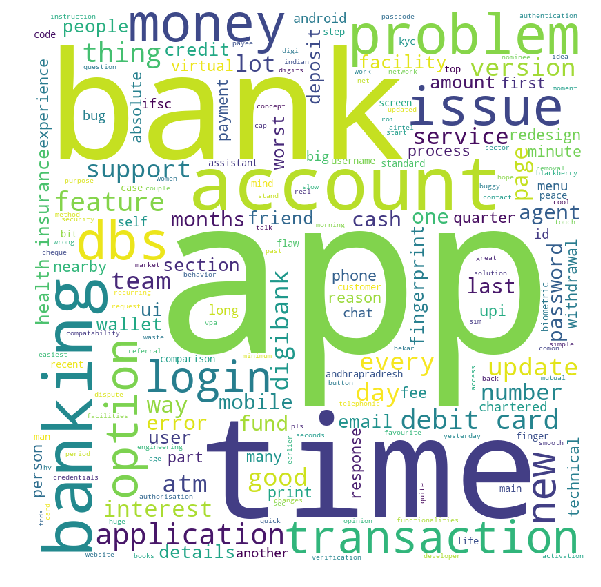

In [14]:
# remove debuger
# %%pixie_debugger
from wordCloud import showWordCloud
showWordCloud(topicCollection)
    

In [52]:
#get too N most discussed topics
from collections import Counter
# print(Counter(topicCollection))


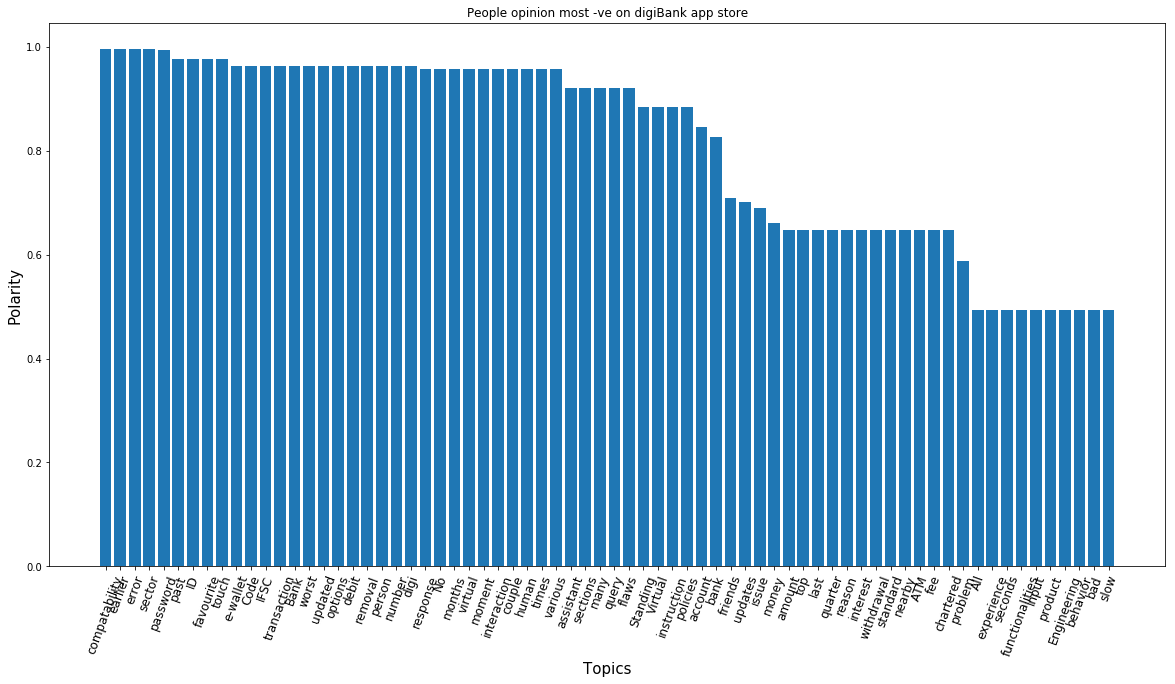

In [91]:
import matplotlib.pyplot as plt
import numpy as np

def showBarCharForSentiment(dataMap):
    # this is for plotting purpose
    labels = []
    polarity = []
  
    for i in dataMap[: 70]:
        labels.append(i[0])
        polarity.append(i[1])

    plt.figure(figsize=(20, 10)) 
    x = np.arange(len(polarity))
    plt.bar(x, polarity)
    plt.xlabel('Topics', fontsize=15)
    plt.ylabel('Polarity', fontsize=15)
    plt.xticks(x, labels, fontsize=12, rotation=70)
    plt.title('People opinion most -ve on digiBank app store')

showBarCharForSentiment(d_sorted_by_value)

In [11]:
import numpy as np

dataToStore = {
    'topic': topicColumn,
    'Negative': sentimentColumn
}
# print(topicCollection)
df = pd.DataFrame(dataToStore)
df.to_csv(output_file_path, sep='\t', encoding='utf-8')